## Марковские случайные процессы, построение марковских моделей для временных рядов, прогнозирование значений

# Материалы

- http://quantile.ru/11/11-CK.pdf

# Домашнее задание

- Скачайте текст войны и мир (ссылка на [github](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [гугл диск](https://drive.google.com/drive/u/2/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU)). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов
- [Выберите ряд](https://datamarket.com/data/list/?q=cat:fpg%20provider:tsdl) и оцените его через HMM. Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [61]:
!pip install hmmlearn

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
sns.set()
from hmmlearn.hmm import GaussianHMM

# ВОЙНА И МИР 

In [2]:
((np.exp(1)-2.7)*100000).round(4)

1828.1828

[СТОИТ ЛИ ИСПОЛЬЗОВАТЬ PYTHON RE.COMPILE?](https://www.rupython.com/python-re-compile-882.html])

Если используется только одно регулярное выражение многократно, стоит.  
И код становится более естественным для восприятия.  
У нас такой именно такой случай, поэтому воспользуемся.  

In [3]:
regex = re.compile("[а-я]+")

### Создадим функцию, которая находит только слова

In [4]:
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

### Загружаем все файлы (4 тома "Война и Мир"), оставляя только буквы и переводим их все в нижний регистр.  
**Надо запомнить: работаешь с русскими шрифтами, скорей всего понадобится кодировка 'encoding="utf-8"'!!!**

In [5]:
text = ""
for i in range(1, 5):
    with open(f'war_and_peace/tom_{i}.txt', 'r', encoding="utf-8") as file:
        tom = file.read().lower()
    
    text = text + words_only(tom) + " "

In [ ]:
text

### Матрица переходных вероятностей.

In [6]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS_RU = {l: i for i, l in enumerate(RUSSIAN)}

In [7]:
probabilities_ru = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [8]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities_ru[POS_RU[cp], POS_RU[cn]] += 1

In [9]:
probabilities_ru = (probabilities_ru / probabilities_ru.sum(axis=1)[:, None])

In [10]:
df = pd.DataFrame(probabilities_ru, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

### Визиализируем вероятности следования символов друг за другом (матрицу переходных вероятностей) с помощью **тепловой карты**.

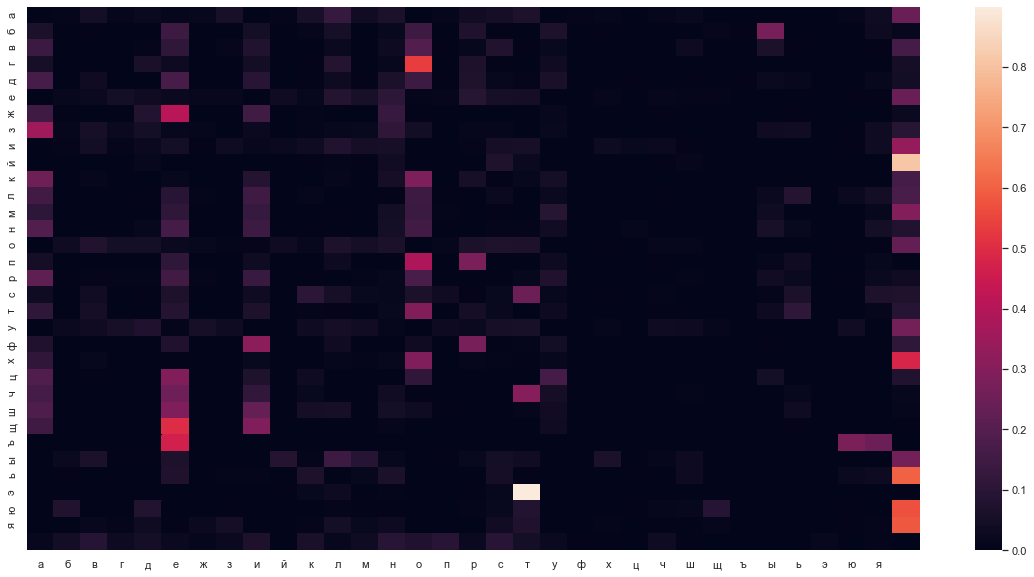

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(df, xticklabels=list(RUSSIAN), yticklabels=list(RUSSIAN))
plt.show()

### Посчитаем вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р.

In [12]:
def get_letter_and_prob(prev_letter=None, alfabet=RUSSIAN, probabilities=probabilities_ru, POS=POS_RU):
    if prev_letter is None:
        for s in list(alfabet):
            yield s, probabilities[POS[' '], POS[s]]
    else:
        for s in list(alfabet):
            yield s, probabilities[POS[prev_letter], POS[s]]

In [13]:
words = []
s1 = 'п'
s4 = 'р'
p1 = 1./len(RUSSIAN)
for s2, p2 in get_letter_and_prob(s1):
    for s3, p3 in get_letter_and_prob(s2):
        p4 = probabilities_ru[POS_RU[s3], POS_RU[s4]]
        words.append((s1 + s2 + s3 + s4, p1 * p2 * p3 * p4))

In [14]:
words = sorted(words, key = lambda w: w[1], reverse=True)
words[:20]

[('прер', 0.00012335774136099814),
 ('прор', 9.365605562565728e-05),
 ('прар', 7.633171199780586e-05),
 ('по р', 6.769704247051618e-05),
 ('потр', 4.18492411696942e-05),
 ('попр', 4.1027899749022824e-05),
 ('погр', 3.945928989911442e-05),
 ('подр', 3.918739476068601e-05),
 ('побр', 3.003295011537867e-05),
 ('поер', 2.6507413545261443e-05),
 ('пе р', 2.063622671537994e-05),
 ('пь р', 1.7392765252158383e-05),
 ('прур', 1.5698946906936143e-05),
 ('повр', 1.4618331706949343e-05),
 ('пепр', 1.2102500324004539e-05),
 ('пегр', 1.1397497058526789e-05),
 ('прир', 1.0008821408897551e-05),
 ('покр', 9.999234295523943e-06),
 ('па р', 9.695353027294278e-06),
 ('пофр', 9.201387447410195e-06)]

Вероятности - вероятностями. Но интересно, бывают ли такие слова на самом деле. Тем более в Войне и мир. Например... попр... поправляйся... прер...  пререгатива.. подр... сподручно. Но в любом случае, надо понимать, что не обязательно найденная двадцатка возможных последовательностей символов, включая пробел найдётся в самом тексте.  
А как называется взаимоотношение истинных слов и вероятностных слов? Тоже большое поле для размышлений.  

Это мы показали первую двадцатку, а чтобы ответить на поставленный вопрос, просуммируем все вероятности.

In [15]:
prob = sum([w[1] for w in words])
print('Вероятность встретить строку из четырёх символов, которая начинается п, а кончается на р:', prob.round(8))

Вероятность встретить строку из четырёх символов, которая начинается п, а кончается на р: 0.0009785


### Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов

#### Создадим функцию, которая генерит нам требуемое слово.

In [16]:
def gen_word(start='б', length=8):
    
    word = start # В переменную бросаем нашу первую букву. Потом будем добавлять.
    prev_letter = start # Чтобы генерить следующую букву, надо знать предшествующую
    
    for i in range(length-1):
        while True: 
            next_letter = np.random.choice(list(RUSSIAN), p=probabilities_ru[POS_RU[prev_letter]])
            if next_letter != ' ': # Дополнительное условие, чтобы внутри слова не было пробела.
                word += next_letter
                prev_letter = next_letter
                break
    
    # Добавим естественое условие: после крайнего символа в слове должен быть пробел
    probas = []
    letters = []
    for l in RUSSIAN[:-1]:
        proba = probabilities_ru[POS_RU[prev_letter], POS_RU[l]] * probabilities_ru[POS_RU[l], POS_RU[' ']]
        if proba > 0:
            probas.append(proba)
            letters.append(l)
    
    probas = probas / sum(probas)
    word += np.random.choice(letters, p=probas)
    
    return word

Сгенерим слово:

In [60]:
gen_word()

'блавыйчик'

# [Выберите ряд](https://datamarket.com/data/list/?q=cat:fpg%20provider:tsdl) и оцените его через HMM. Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [44]:
df = pd.read_excel("Qlik Sense - Значения - 17 августа 2020 г..xlsx")

In [45]:
df

,Invoice Date,Sales,Sales Qty
0,2018-08-31 00:00:00,186136.88,1357.0
1,2019-09-01 00:00:00,154600.66,2505.0
2,2018-09-01 00:00:00,99586.89,1215.0
3,2019-09-02 00:00:00,186220.98,831.0
4,2018-09-02 00:00:00,86921.68,1619.0
...,...,...,...
614,2018-08-29 00:00:00,111213.64,876.0
615,2019-08-30 00:00:00,121093.14,2945.0
616,2018-08-30 00:00:00,180695.52,2219.0
617,2019-08-31 00:00:00,245091.03,1971.0


In [46]:
series = df['Sales']
values = series.values.reshape(-1,1)

In [48]:
scores = []
for n in tqdm(range(1, 26)):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    scores.append((n, model.score(values)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Fitting a model with 623 free scalar parameters with only 619 data points will result in a degenerate solution.
Fitting a model with 674 free scalar parameters with only 619 data points will result in a degenerate solution.


При значениях компонент больше или равных 24 начинается нехватка данных, причём эта зависимость линейная. Максимальное количество допустимых компонент у нас n=23, дальше идет переобучение.

In [50]:
scores

[(1, -8211.866287478575),
 (2, -8047.985364137177),
 (3, -8010.186065524719),
 (4, -8002.839037058988),
 (5, -7972.941092818428),
 (6, -7959.8310662556505),
 (7, -7953.001012673017),
 (8, -7942.632983286794),
 (9, -7929.830345926492),
 (10, -7918.883616447456),
 (11, -7905.386960787117),
 (12, -7895.129492891322),
 (13, -7880.944594950216),
 (14, -7859.436180132746),
 (15, -7856.634359353691),
 (16, -7850.26319443922),
 (17, -7835.173745208196),
 (18, -7818.232892312314),
 (19, -7789.179925098011),
 (20, -7788.398154641777),
 (21, -7762.763884480702),
 (22, -7749.3758055938115),
 (23, -7723.263799613931),
 (24, -7718.934973979216),
 (25, -7697.3366959203495)]

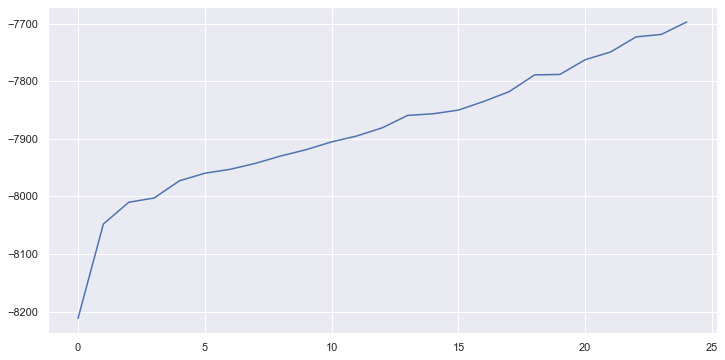

In [51]:
plt.figure(figsize=(12, 6))
plt.plot([x[1] for x in scores ])

Чем больше компонент, тем лучше должен быть прогноз. Единственное есть потолок по количеству компонент в зависимости от количества данных во временном ряду. Иначе будет переобучение. Обучим две модели с разным количеством компонент и отобразим на общем графике.

In [52]:
model11 = GaussianHMM(n_components=11, covariance_type="diag", n_iter=1000)
model11.fit(values)
labels11 = model11.predict(values)
means11 = np.zeros_like(values)
for i in range(model11.n_components):
    means11[labels11 == i] = model11.means_[i]

In [53]:
model22 = GaussianHMM(n_components=22, covariance_type="diag", n_iter=1000)
model22.fit(values)
labels22 = model22.predict(values)
means22 = np.zeros_like(values)
for i in range(model22.n_components):
    means22[labels22 == i] = model22.means_[i]

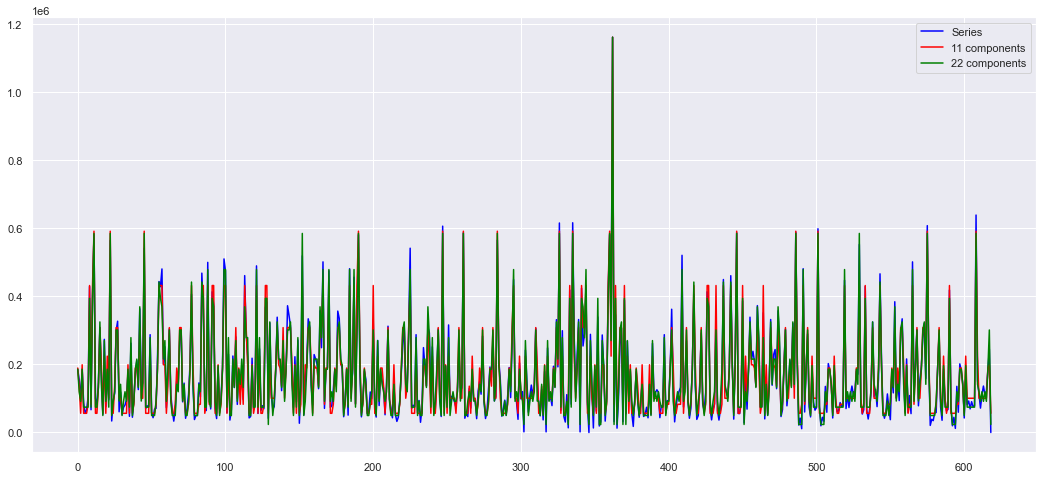

In [54]:
plt.figure(figsize=(18, 8))
plt.plot(values, color='blue', label='Series')
plt.plot(means11, color='red', label='11 components')
plt.plot(means22, color='green', label='22 components')
plt.legend()

В районе значения 370 полезно посмотреть графики.

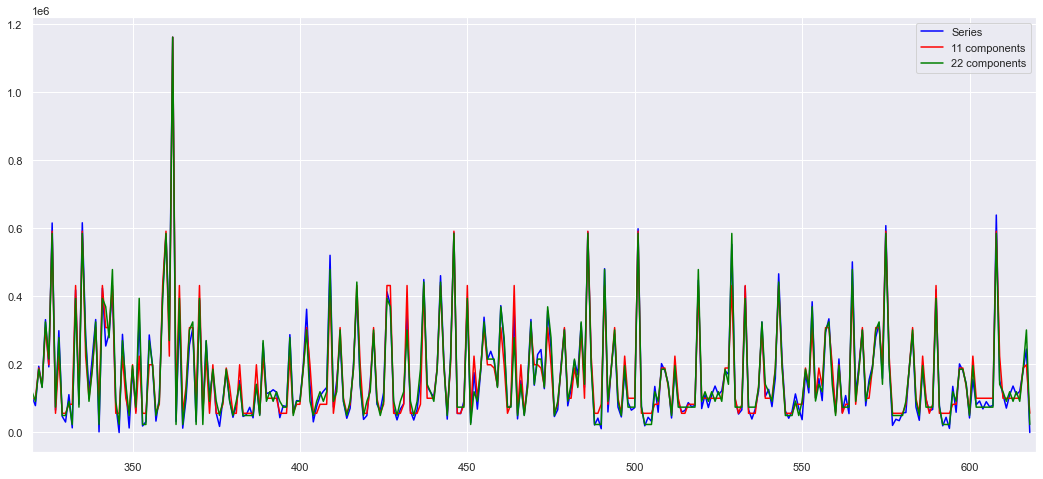

In [70]:
plt.figure(figsize=(18, 8))
plt.plot(values, color='blue', label='Series')
plt.plot(means11, color='red', label='11 components')
plt.plot(means22, color='green', label='22 components')
plt.xlim(320.0, 620.0)
plt.legend()

По сути оба графика повотряют наш временной ряд, конечно 22 компоненты дают более близкий по отношению к первоначальному временному ряду результат.

#### Займёмся предсказаниями.

In [74]:
def hmm_predict(labels, model, n_comp, n_preds=20):
    cur_value = labels[-1]
    predictions = []
    for _ in range(n_preds):
        cur_value = np.random.choice(n_comp, p=model.transmat_[cur_value])
        predictions.append(model.means_[cur_value])
    return predictions

In [75]:
pred11 = np.concatenate((values, hmm_predict(labels11, model11, 11)))
pred22 = np.concatenate((values, hmm_predict(labels22, model22, 22)))

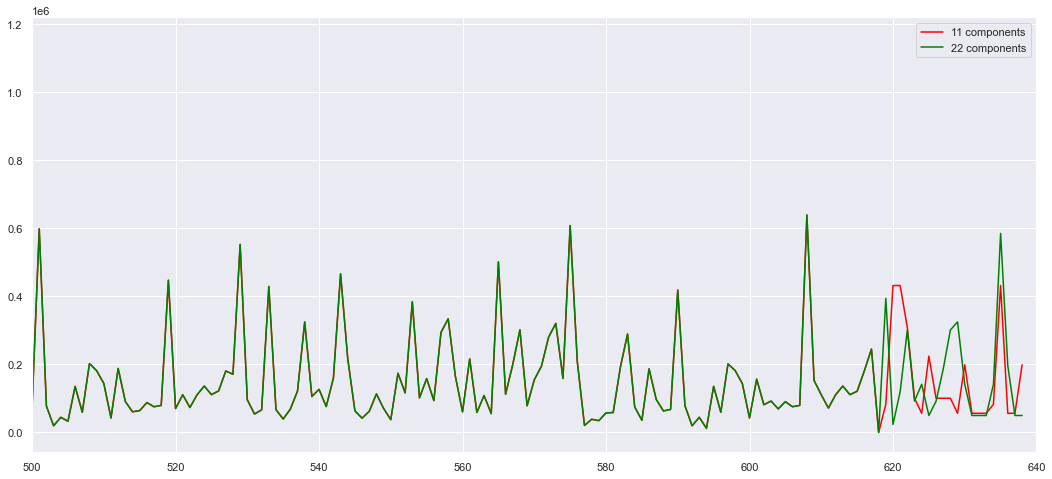

In [77]:
plt.figure(figsize=(18, 8))
plt.plot(pred11, color='red', label='11 components')
plt.plot(pred22, color='green', label='22 components')
plt.xlim(500.0, 640.0)
plt.legend()